In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer


In [4]:
amesprice= pd.read_csv("Ames_HousePrice.csv")
amesreal= pd.read_csv("Ames Real Estate Data.csv", dtype='object', index_col = 0)

In [5]:
amesreal.head()

,GeoRefNo,Tier,Range,Prop_Addr,ZngCdPr,ZngCdSc,ZngOLPr,ZngOLSc,ClassPr_S,ClassSc_S,...,PA-Nmbr,PA-PreD,PA-Strt,PA-StSfx,PA-PostD,PA-UnTyp,PA-UntNo,Date,Source,NmbrBRs
MapRefNo,,,,,,,,,,,,,,,,,,,,,
520400001,0520400001,0,0,4599 GEORGE W CARVER AVE,FS-RL,NaN,NaN,NaN,RESIDENTIAL,VACANT LAND - IMPROVED OR UNIMPROVED,...,4599,NaN,GEORGE W CARVER,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,NaN
520440010,0520440010,0,0,4507 EVEREST AVE,FS-RL,NaN,NaN,NaN,RESIDENTIAL,VACANT LAND - IMPROVED OR UNIMPROVED,...,4507,NaN,EVEREST,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,NaN
520440020,0520440020,0,0,4513 EVEREST AVE,FS-RL,NaN,NaN,NaN,RESIDENTIAL,VACANT LAND - IMPROVED OR UNIMPROVED,...,4513,NaN,EVEREST,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,NaN
520445001,0520445001,0,0,3449 BARCELOS ST,FS-RL,NaN,NaN,NaN,RESIDENTIAL,ASSOCIATION COMMON AREA,...,3449,NaN,BARCELOS,ST,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,NaN
520445010,0520445010,0,0,4506 EVEREST AVE,FS-RL,NaN,NaN,NaN,RESIDENTIAL,VACANT LAND - IMPROVED OR UNIMPROVED,...,4506,NaN,EVEREST,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,NaN


In [6]:
amesprice.head()

,Unnamed: 0,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,2,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
2,3,911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
3,4,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,...,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
4,5,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal


# Cleaning the Data

In [7]:
amesprice.info()
amesreal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     2580 non-null   int64  
 1   PID            2580 non-null   int64  
 2   GrLivArea      2580 non-null   int64  
 3   SalePrice      2580 non-null   int64  
 4   MSSubClass     2580 non-null   int64  
 5   MSZoning       2580 non-null   object 
 6   LotFrontage    2118 non-null   float64
 7   LotArea        2580 non-null   int64  
 8   Street         2580 non-null   object 
 9   Alley          168 non-null    object 
 10  LotShape       2580 non-null   object 
 11  LandContour    2580 non-null   object 
 12  Utilities      2580 non-null   object 
 13  LotConfig      2580 non-null   object 
 14  LandSlope      2580 non-null   object 
 15  Neighborhood   2580 non-null   object 
 16  Condition1     2580 non-null   object 
 17  Condition2     2580 non-null   object 
 18  BldgType

Fence          79.651163
Alley          93.488372
MiscFeature    96.240310
PoolQC         99.651163
dtype: float64


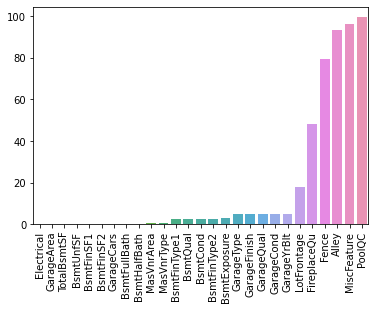

In [8]:
#figure out which columns to get rid of if too many null values

def percent_null(amesprice):
    percentmis = 100* amesprice.isnull().sum() / len(amesprice)
    return percentmis
percentmis=percent_null(amesprice)


percentmis = percentmis[percentmis>0].sort_values()
sns.barplot(x= percentmis.index, y=percentmis)
plt.xticks(rotation=90)
print(percentmis[percentmis>=75])

In [9]:
'''

Data Cleaning- seeing null variables and which should be filled in or dropped

Dropped Contenders
LotFrontage      is approx. 20% null and has similar info to LotArea. could be dropped
Alley            is mostly null and should be dropped
FireplaceQu      1241
Fence            2055
MiscFeature      2483

Fillna contenders

MasVnrType       should have nulls filled
Electrical-1 null
BsmtFullBath        2
BsmtHalfBath        2

Interesting that theres so many basement variables- are all necessary?
BsmtQual           69
BsmtCond           69
BsmtExposure       71
BsmtFinType1       69
BsmtFinSF1          1
BsmtFinType2       70
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1

GarageType        127
GarageYrBlt       129
GarageFinish      129
GarageCars          1
GarageArea          1
GarageQual        129
GarageCond        129
'''


amesprice['MasVnrType']=amesprice['MasVnrType'].replace(np.nan, 'None')


garagbaseordinal=['GarageType','GarageFinish','GarageQual','GarageCond','GarageYrBlt',
                  'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for x in garagbaseordinal:
    amesprice[x]=amesprice[x].replace(np.nan,'NA')

garagenum=['GarageCars','GarageArea', 'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF',
           'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea', 'TotalBsmtSF' ]
for y in garagenum:
    amesprice[y]=amesprice[y].replace(np.nan, 0)
    
amesprice.isnull().sum()

Unnamed: 0       0
PID              0
GrLivArea        0
SalePrice        0
MSSubClass       0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 82, dtype: int64

In [10]:
#dropping these columns because of excessive null values
amesprice.drop(['PoolQC','LotFrontage','Alley', 'FireplaceQu', 'Fence','MiscFeature'],
               inplace=True, axis=1)


# EDA of the Ames Saleprice Data

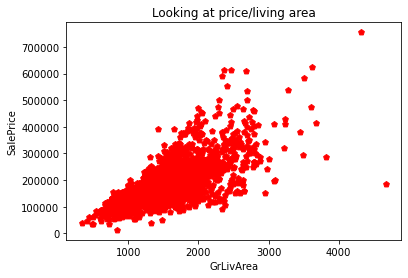

In [12]:
plt.scatter(amesprice.GrLivArea, amesprice.SalePrice, c = "red", marker = "p")
plt.title("Looking at price/living area")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [13]:
print("minimum price: ",amesprice.SalePrice.min())
print("maximum price: ",amesprice.SalePrice.max())
print("average price: ",amesprice.SalePrice.mean())
print("median price: ",amesprice.SalePrice.median())
print("mode price: ",amesprice.SalePrice.mode())
#finding the minimum and max, mean, median and mode price

minimum price:  12789
maximum price:  755000
average price:  178059.62325581396
median price:  159900.0
mode price:  0    135000
dtype: int64


<AxesSubplot:>

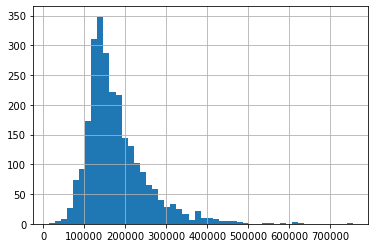

In [14]:
amesprice.SalePrice.hist(bins=50)
#looking at the distribution of the prices

In [15]:
corr = amesprice.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice        1.000000
OverallQual      0.790501
GrLivArea        0.719981
TotalBsmtSF      0.652494
1stFlrSF         0.642613
GarageCars       0.638424
GarageArea       0.634669
YearBuilt        0.544370
FullBath         0.534982
YearRemodAdd     0.514309
MasVnrArea       0.498432
TotRmsAbvGrd     0.490219
Fireplaces       0.488184
BsmtFinSF1       0.461070
WoodDeckSF       0.333232
OpenPorchSF      0.306540
BsmtFullBath     0.290755
HalfBath         0.285875
LotArea          0.274443
2ndFlrSF         0.263144
BsmtUnfSF        0.168060
BedroomAbvGr     0.151806
ScreenPorch      0.121463
3SsnPorch        0.031260
PoolArea         0.030844
BsmtFinSF2       0.022668
MoSold           0.012591
YrSold          -0.001376
MiscVal         -0.018877
Unnamed: 0      -0.028413
LowQualFinSF    -0.030835
BsmtHalfBath    -0.033786
MSSubClass      -0.084587
OverallCond     -0.101091
KitchenAbvGr    -0.113977
EnclosedPorch   -0.123235
PID             -0.226276
Name: SalePrice, dtype: float64


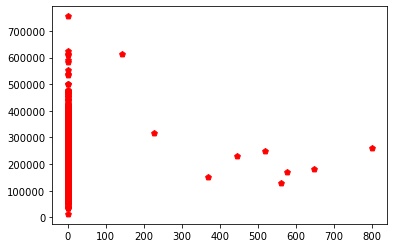

In [17]:
#just seeing if theres a relationship between having a pool and sales price
plt.scatter(amesprice.PoolArea, amesprice.SalePrice, c = "red", marker = "p")

In [18]:
amesprice.columns

Index(['Unnamed: 0', 'PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDec

<AxesSubplot:>

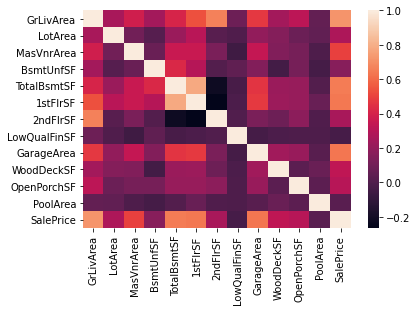

In [20]:
#Finding columns with size related data to compare to saleprice

size_related = amesprice.filter(regex='SF$|Area$')
corr = pd.concat([size_related, amesprice['SalePrice']], axis=1).corr()
sns.heatmap(corr)

In [21]:
print(corr[corr>0.5]) #0.5 to 0.7 is moderate correlation

#based on this- GrLivArea, TotalBsmtSF, 1stFlrSF, GarageArea have 
# the highest correllations with saleprice of the size related columns

              GrLivArea  LotArea  MasVnrArea  BsmtUnfSF  TotalBsmtSF  \
GrLivArea      1.000000      NaN         NaN        NaN          NaN   
LotArea             NaN      1.0         NaN        NaN          NaN   
MasVnrArea          NaN      NaN         1.0        NaN          NaN   
BsmtUnfSF           NaN      NaN         NaN        1.0          NaN   
TotalBsmtSF         NaN      NaN         NaN        NaN     1.000000   
1stFlrSF       0.539135      NaN         NaN        NaN     0.784271   
2ndFlrSF       0.665001      NaN         NaN        NaN          NaN   
LowQualFinSF        NaN      NaN         NaN        NaN          NaN   
GarageArea          NaN      NaN         NaN        NaN          NaN   
WoodDeckSF          NaN      NaN         NaN        NaN          NaN   
OpenPorchSF         NaN      NaN         NaN        NaN          NaN   
PoolArea            NaN      NaN         NaN        NaN          NaN   
SalePrice      0.719981      NaN         NaN        NaN     0.65

/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

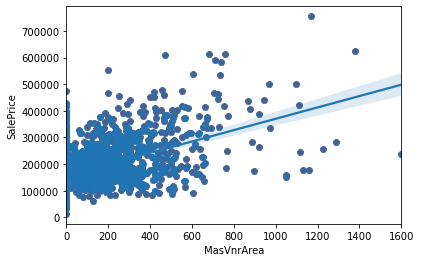

In [22]:
plt.scatter(amesprice.MasVnrArea, amesprice.SalePrice, c = "red", marker = "p")
sns.regplot(amesprice.MasVnrArea, amesprice.SalePrice)

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

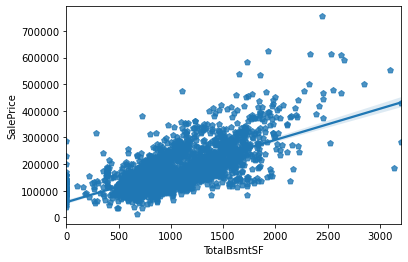

In [27]:
#plotting basement sf vs. saleprice- shows a correlation in houses with basements

sns.regplot(amesprice.TotalBsmtSF, amesprice.SalePrice, marker = "p")

/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

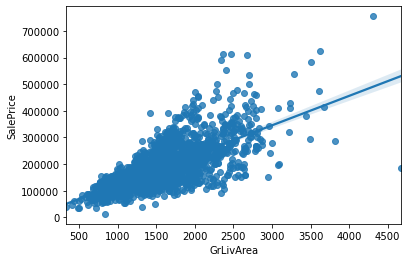

In [24]:
#plotting GrLivArea vs. Sale price- this column has highest correlation with saleprice 
sns.regplot(amesprice.GrLivArea, amesprice.SalePrice)

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

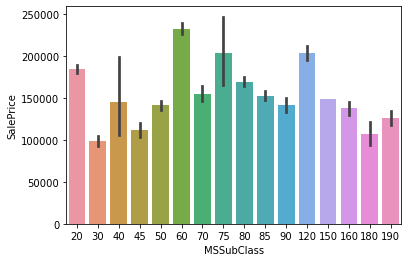

In [28]:
sns.barplot(x='MSSubClass', y='SalePrice', data=amesprice)
#  60	2-STORY 1946 & NEWER has the highest value

<AxesSubplot:xlabel='BldgType', ylabel='SalePrice'>

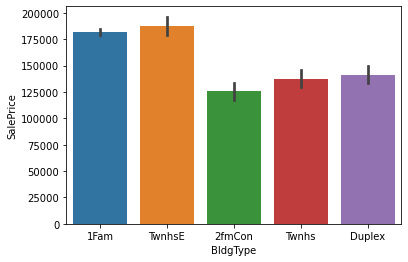

In [29]:
sns.barplot(x='BldgType', y='SalePrice', data=amesprice)
#Townhouse End Unit has highest avg followed by Single-family Detached

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

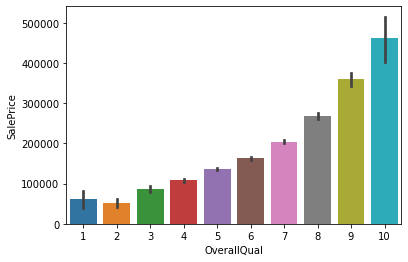

In [30]:
sns.barplot(x='OverallQual',y='SalePrice', data=amesprice)
#obviously higher quality material and finish homes sell for more

<AxesSubplot:xlabel='OverallCond', ylabel='SalePrice'>

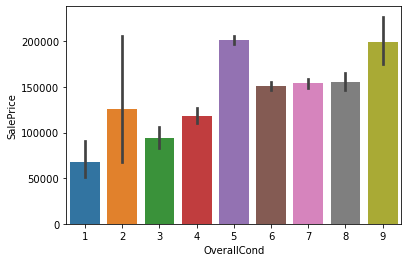

In [31]:
sns.barplot(x='OverallCond',y='SalePrice', data=amesprice)
#average quality houses (rating 5) have a higher mean than 
#quality 9- lets look into this more more

(array([   4.,    8.,   39.,   88., 1402.,  498.,  360.,  140.,   41.]),
 array([1.        , 1.88888889, 2.77777778, 3.66666667, 4.55555556,
        5.44444444, 6.33333333, 7.22222222, 8.11111111, 9.        ]),
 <BarContainer object of 9 artists>)

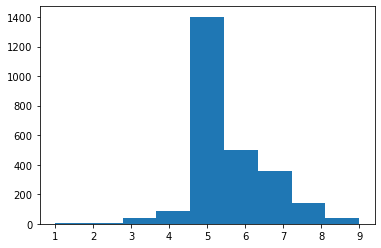

In [32]:
#looks like the majority of houses had a rating of 5 for the condition 
#which would skew the data
plt.hist(x=amesprice['OverallCond'], bins=9)

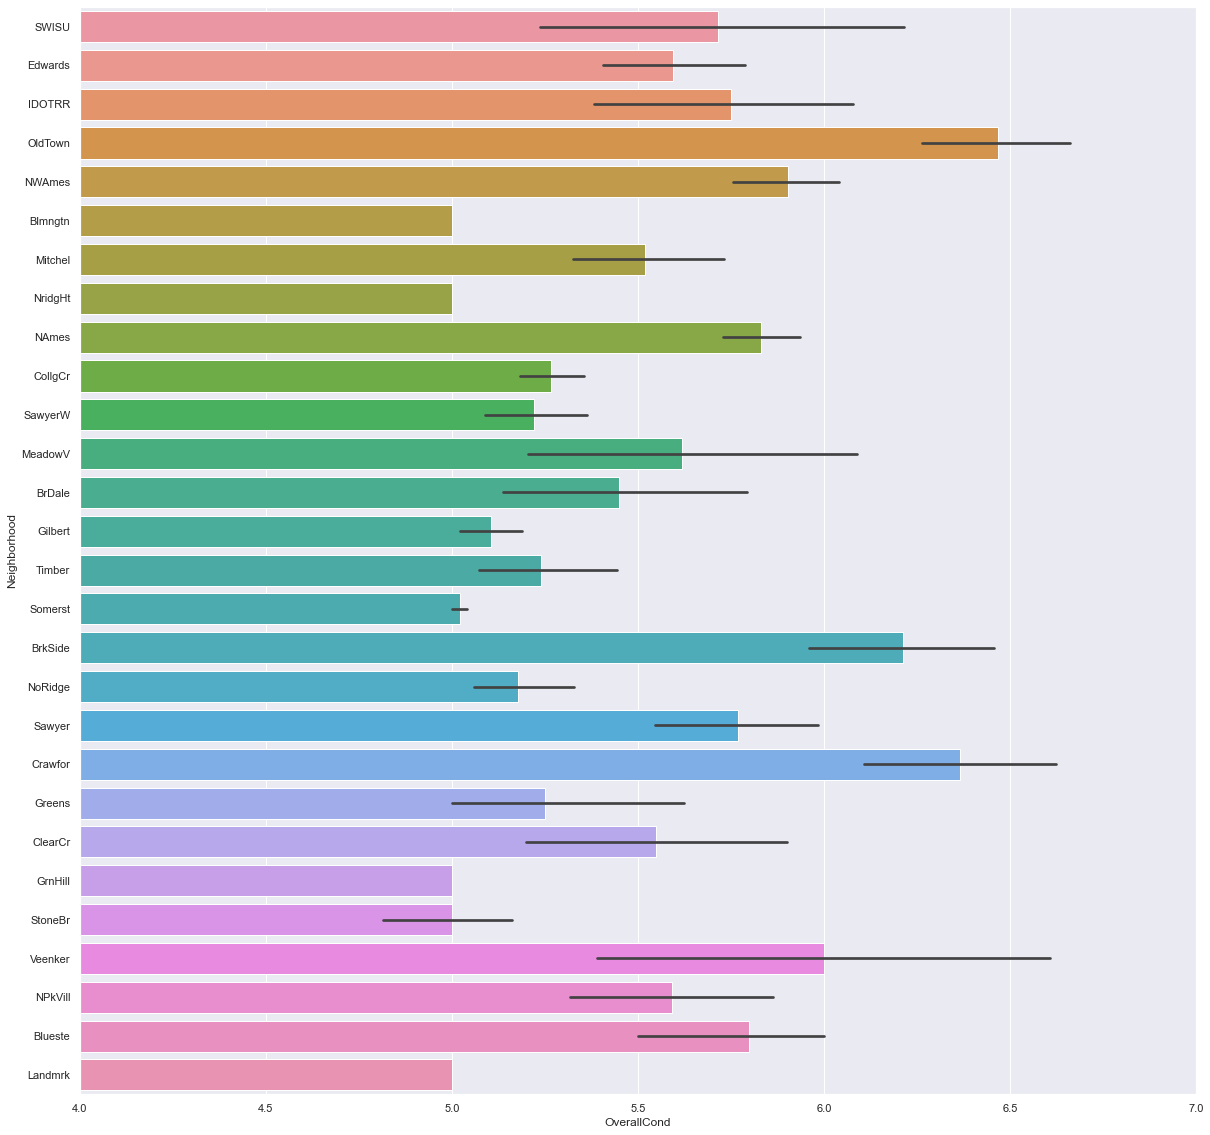

In [47]:
sns.barplot(y='Neighborhood', x='OverallCond', data=amesprice)
plt.xlim(4, 7)
sns.set(rc={"figure.figsize":(20, 20)})
#looks like certain neighborhoods have higher average condition ratings

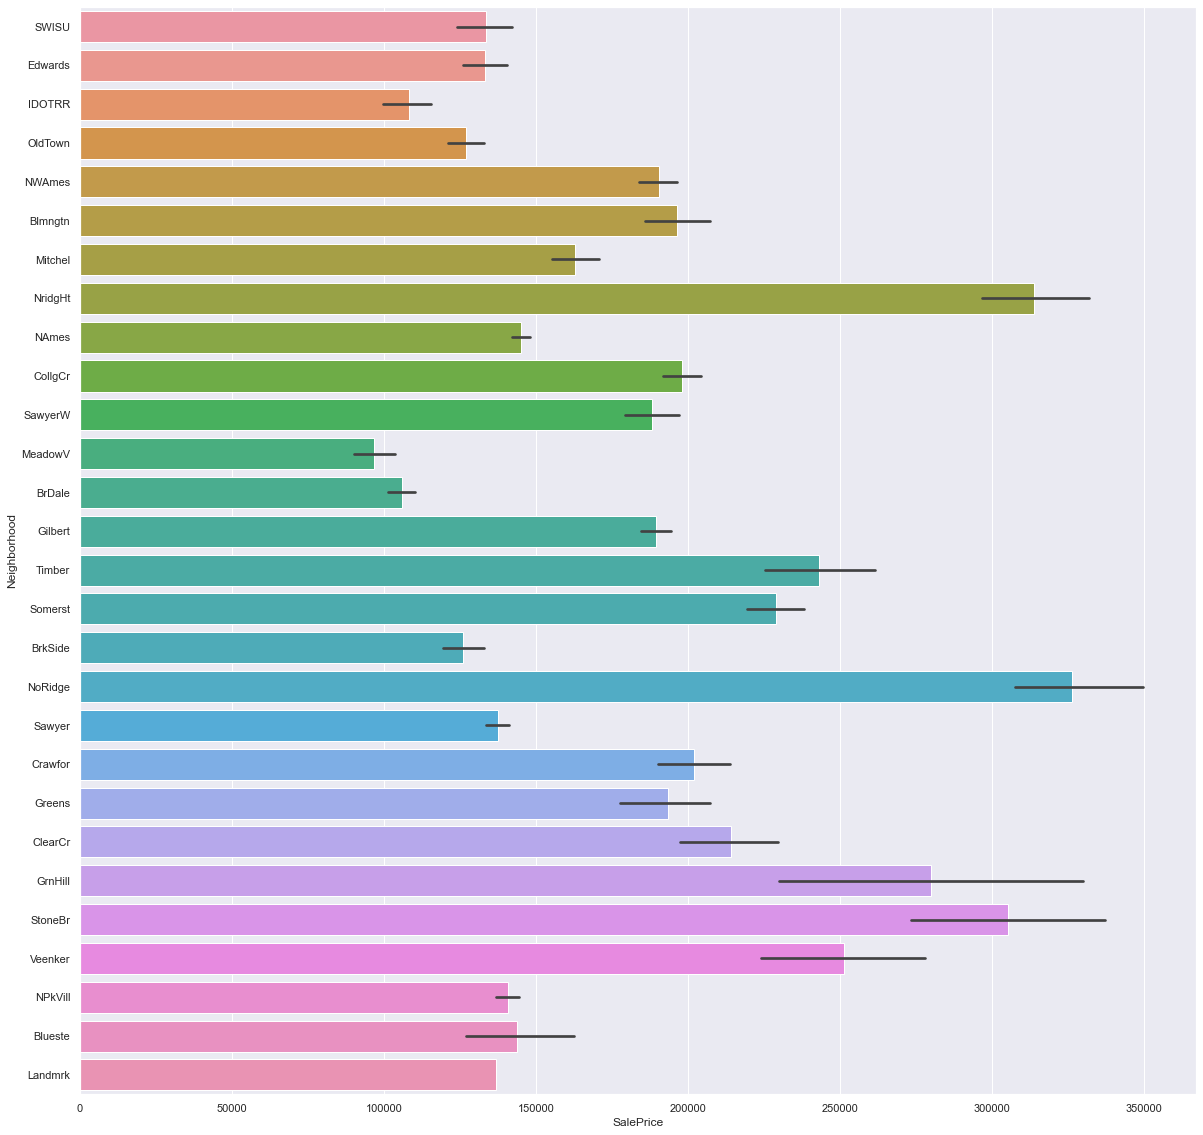

In [46]:
#find which neighborhoods cost more
sns.barplot(y='Neighborhood', x='SalePrice', data=amesprice)
#plt.xticks(rotation=70)
sns.set(rc={"figure.figsize":(20, 20)})

#Northridge Heights         NW- but lower avg condition rating
#Northridge                 NW - lower avg condition rating
#Stone Brook                NO - lower avg condition rating
#have the highest average price - 

#desirable neighborhoods are worth more than house condition

<AxesSubplot:xlabel='Heating', ylabel='SalePrice'>

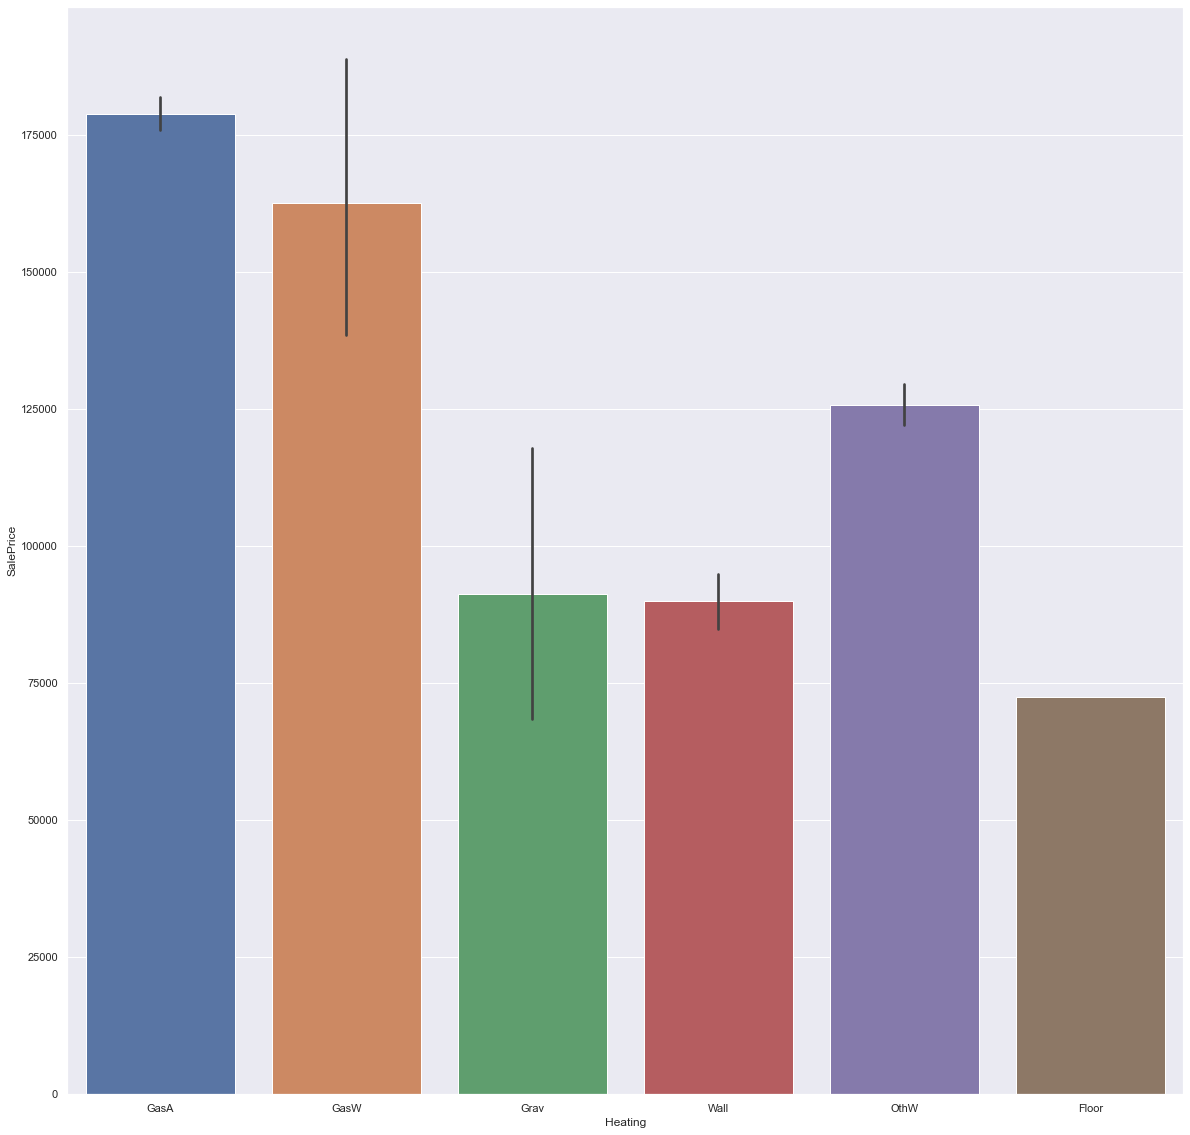

In [48]:
sns.barplot(x='Heating', y='SalePrice', data=amesprice)
#  GasA	Gas forced warm air furnace
#GasW	Gas hot water or steam heat

<AxesSubplot:xlabel='CentralAir', ylabel='SalePrice'>

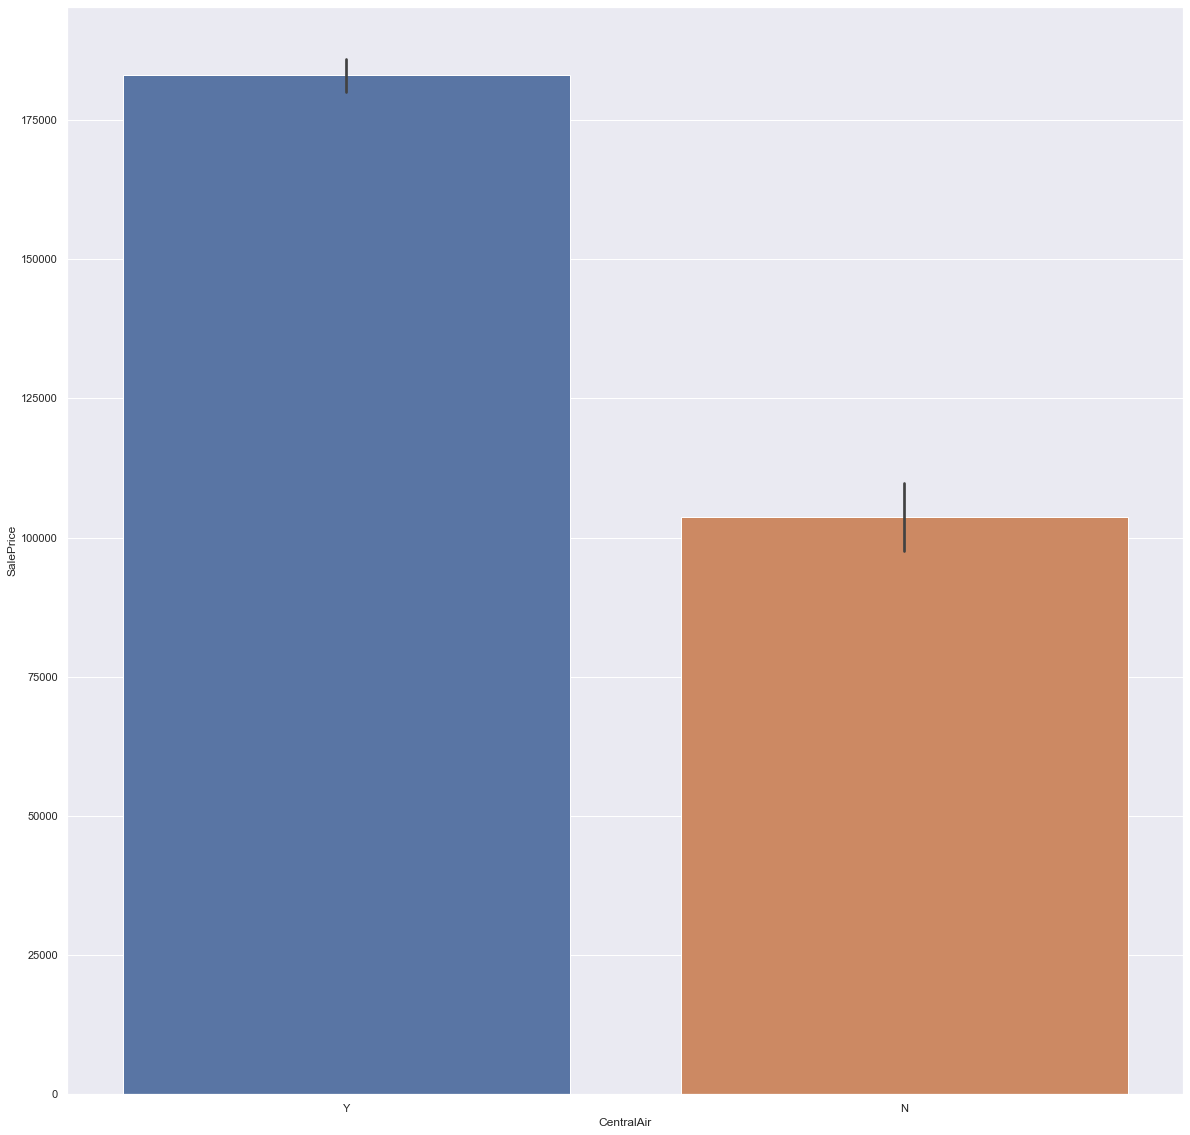

In [49]:
sns.barplot(x='CentralAir', y='SalePrice', data=amesprice)

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

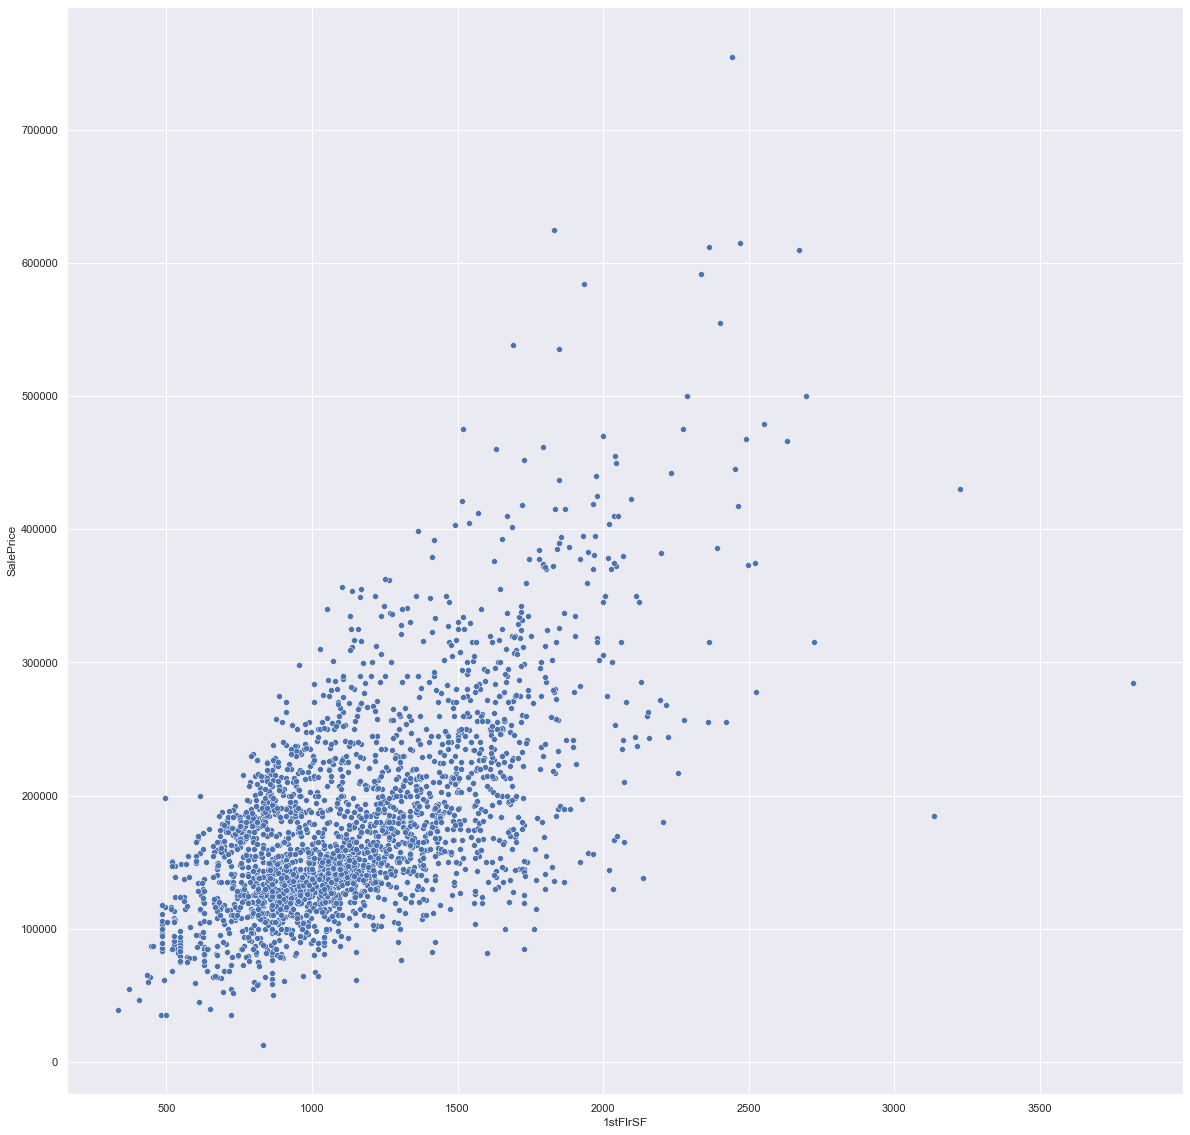

In [50]:
sns.scatterplot(x='1stFlrSF', y='SalePrice', data=amesprice)
#looking at 1stfloor footage vs saleprice since we've seen 
#there is a positive correlation

In [ ]:
sns.jointplot(data=amesprice, x="SaleCondition", y="SaleType", hue="OverallCond", kind="hist")

 #WD 	Warranty Deed - Conventional 
# Normal	Normal Sale

<AxesSubplot:>

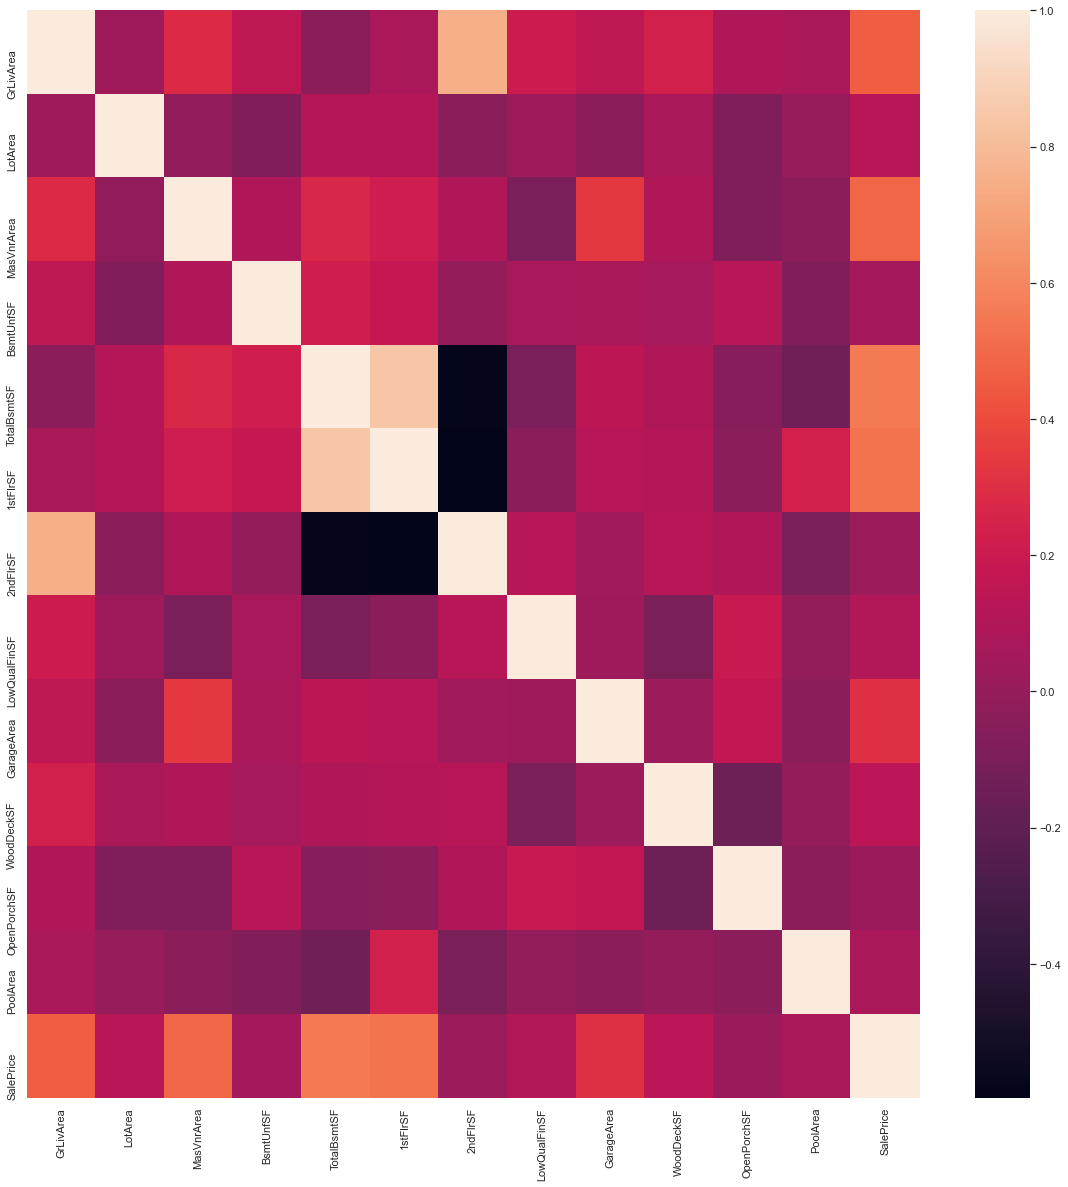

In [54]:
#trying to see if theres any correllations in the more expensive houses

expenhouse=amesprice.loc[(amesprice['SalePrice'] >= 300000)]
expenarea=expenhouse.filter(regex='SF$|Area$')

corr1 = pd.concat([expenarea, expenhouse['SalePrice']], axis=1).corr()
sns.heatmap(corr1)

In [55]:
print(corr1[corr1>0.5])
#in the more expensive houses theres a correllation for sales price
# with TotalBsmtSF & 1stFlrSF  

              GrLivArea  LotArea  MasVnrArea  BsmtUnfSF  TotalBsmtSF  \
GrLivArea      1.000000      NaN         NaN        NaN          NaN   
LotArea             NaN      1.0         NaN        NaN          NaN   
MasVnrArea          NaN      NaN         1.0        NaN          NaN   
BsmtUnfSF           NaN      NaN         NaN        1.0          NaN   
TotalBsmtSF         NaN      NaN         NaN        NaN     1.000000   
1stFlrSF            NaN      NaN         NaN        NaN     0.843833   
2ndFlrSF       0.754963      NaN         NaN        NaN          NaN   
LowQualFinSF        NaN      NaN         NaN        NaN          NaN   
GarageArea          NaN      NaN         NaN        NaN          NaN   
WoodDeckSF          NaN      NaN         NaN        NaN          NaN   
OpenPorchSF         NaN      NaN         NaN        NaN          NaN   
PoolArea            NaN      NaN         NaN        NaN          NaN   
SalePrice           NaN      NaN         NaN        NaN     0.55

In [ ]:
import scipy.stats as st  #if it were normally distributed
st.t.interval(alpha=0.95, df=len(amesprice)-1, loc= 178059.62325581396, scale=st.sem(amesprice.SalePrice))

<AxesSubplot:>

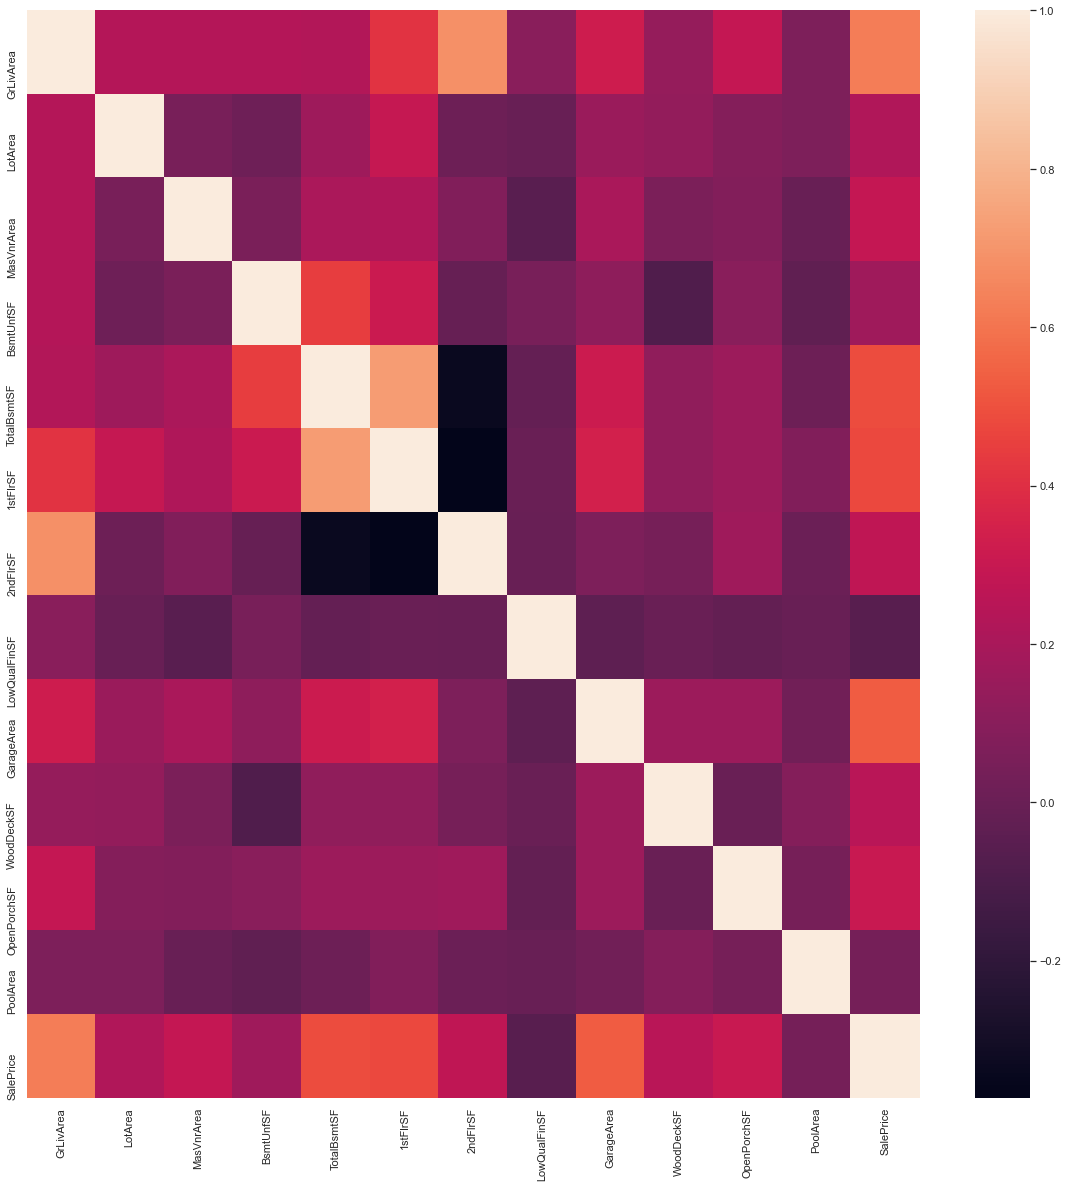

In [57]:
#making a dataframe of moderately priced homes to see their correlations

moderatehome= amesprice.loc[(amesprice['SalePrice'] < 300000) & (amesprice['SalePrice']>95000)]
modsize=moderatehome.filter(regex='SF$|Area$')

corr2 = pd.concat([modsize, moderatehome['SalePrice']], axis=1).corr()
sns.heatmap(corr2)

In [58]:
#finding which columns have a significant correlation with moderate home sales price
print(corr2[corr2>0.5])
#interesting that GarageArea has a correlation in moderately priced homes but not in expensive homes

              GrLivArea  LotArea  MasVnrArea  BsmtUnfSF  TotalBsmtSF  \
GrLivArea      1.000000      NaN         NaN        NaN          NaN   
LotArea             NaN      1.0         NaN        NaN          NaN   
MasVnrArea          NaN      NaN         1.0        NaN          NaN   
BsmtUnfSF           NaN      NaN         NaN        1.0          NaN   
TotalBsmtSF         NaN      NaN         NaN        NaN     1.000000   
1stFlrSF            NaN      NaN         NaN        NaN     0.721326   
2ndFlrSF       0.686499      NaN         NaN        NaN          NaN   
LowQualFinSF        NaN      NaN         NaN        NaN          NaN   
GarageArea          NaN      NaN         NaN        NaN          NaN   
WoodDeckSF          NaN      NaN         NaN        NaN          NaN   
OpenPorchSF         NaN      NaN         NaN        NaN          NaN   
PoolArea            NaN      NaN         NaN        NaN          NaN   
SalePrice      0.629023      NaN         NaN        NaN         

/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


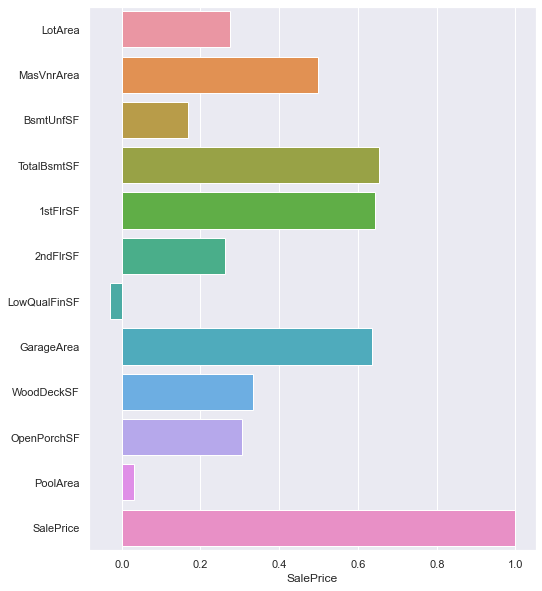

In [59]:
#looking at a bar plot of the different size related variables and their correlation
#with saleprice in relation to each other

corr3 = corr.sort_values('SalePrice', ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( corr.SalePrice[1:], corr.index[1:], orient='h')
plt.show()

In [60]:
corr3 = amesprice.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice       1.000000
GrLivArea       0.719981
TotalBsmtSF     0.652494
1stFlrSF        0.642613
GarageArea      0.634669
MasVnrArea      0.498432
WoodDeckSF      0.333232
OpenPorchSF     0.306540
LotArea         0.274443
2ndFlrSF        0.263144
BsmtUnfSF       0.168060
PoolArea        0.030844
LowQualFinSF   -0.030835
Name: SalePrice, dtype: float64


<AxesSubplot:>

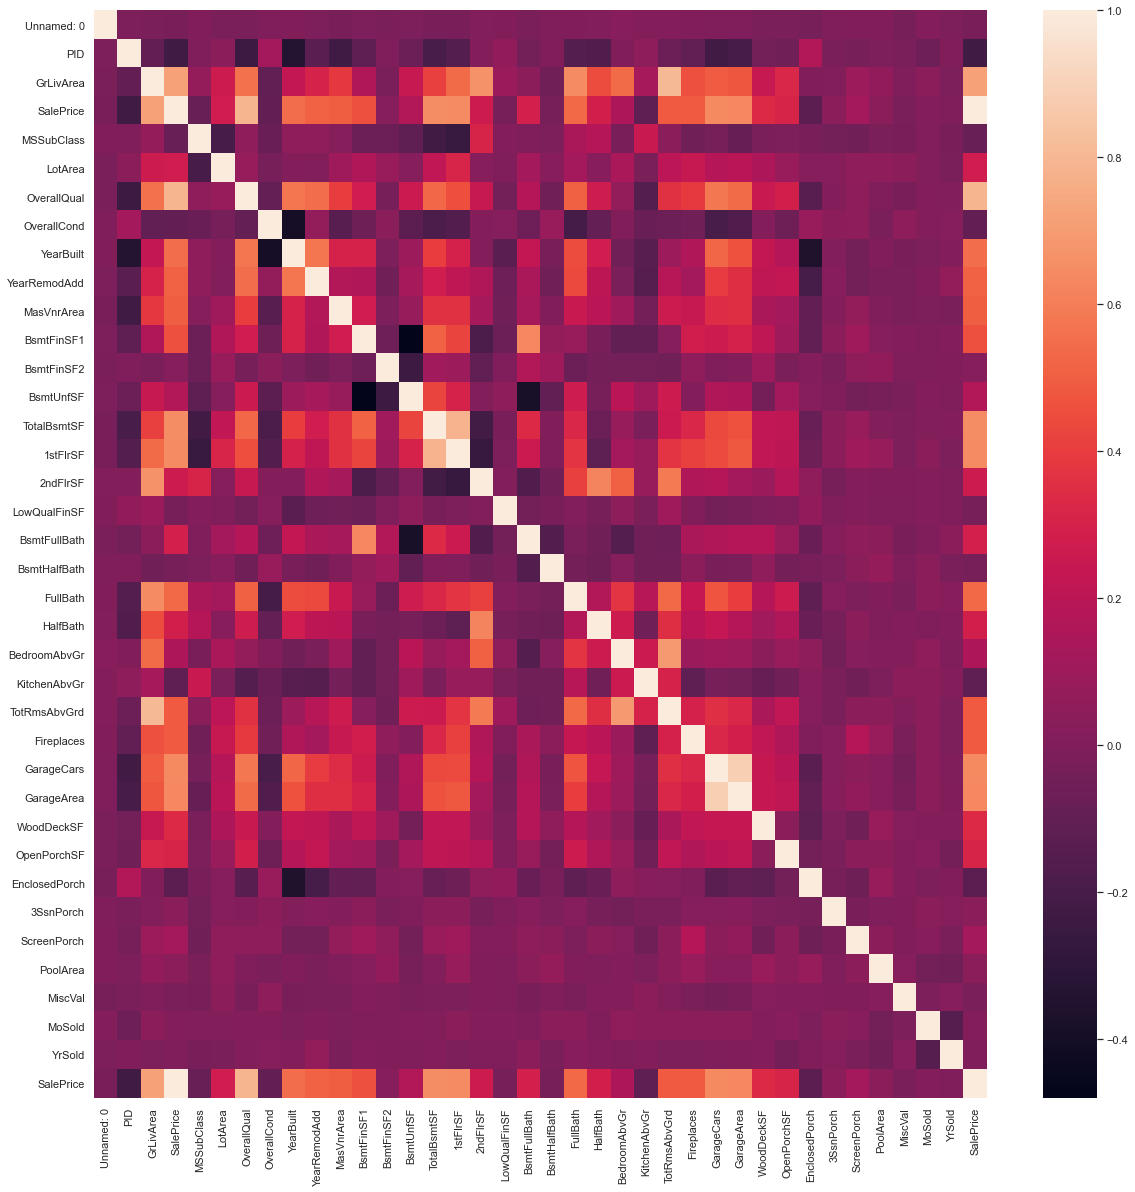

In [63]:
corr3 = pd.concat([amesnum, amesnum['SalePrice']], axis=1).corr()
sns.heatmap(corr3)
#looking at the correlation for all numeric values and sale price

<AxesSubplot:xlabel='YrSold', ylabel='SalePrice'>

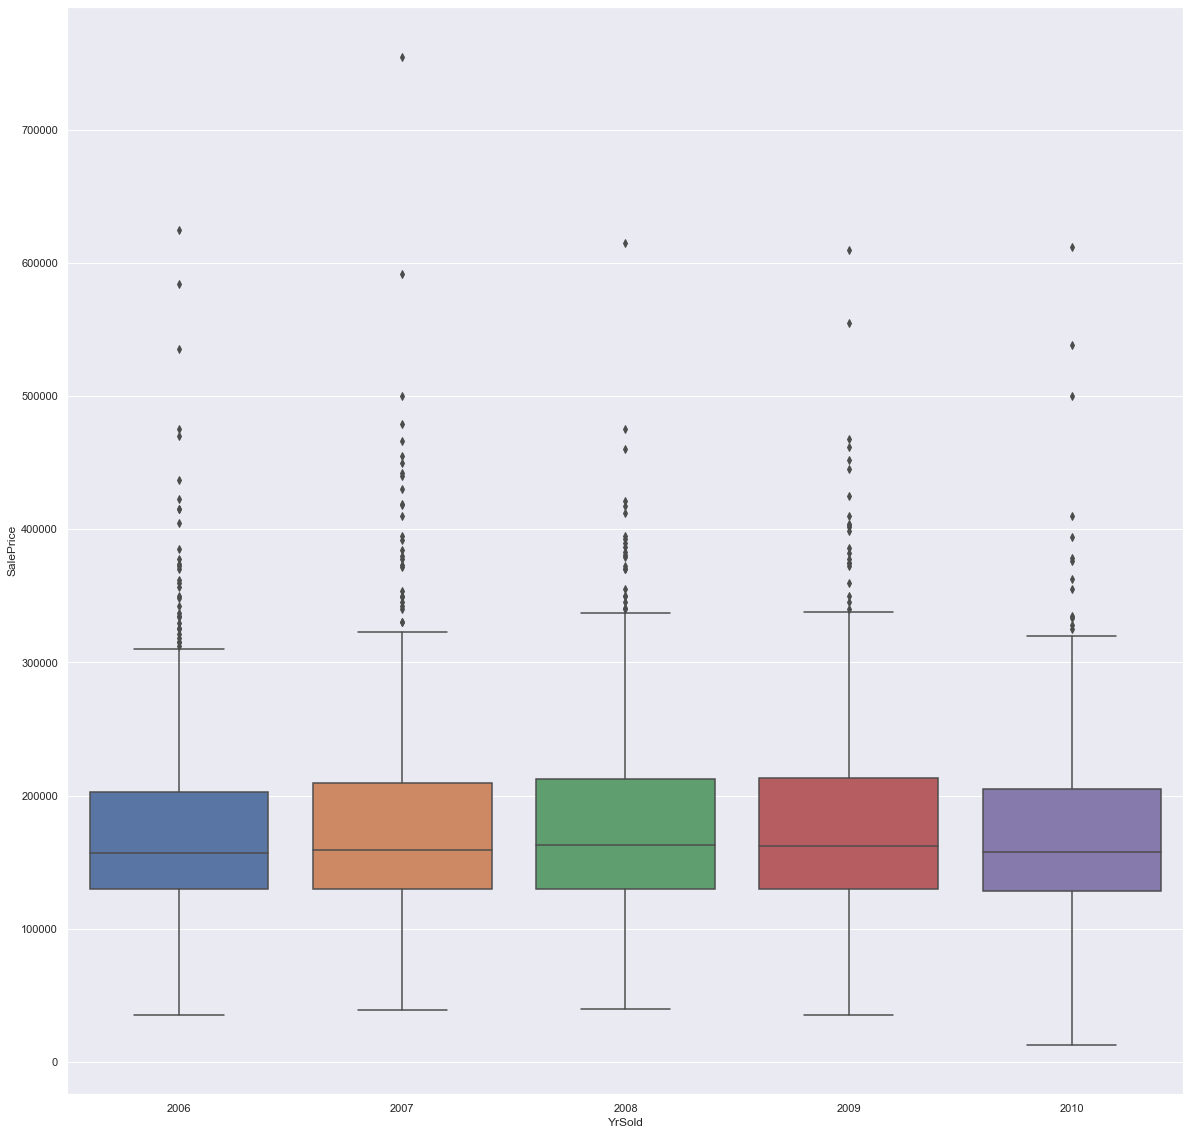

In [65]:
sns.boxplot(x=amesprice['YrSold'], y=amesprice['SalePrice'])

#trying to see if theres any trend in saleprice over time

MoSold
1     193856.227723
2     177285.595041
3     174941.899522
4     167049.781746
5     172817.118457
6     181035.041394
7     180449.995000
8     183253.896373
9     183824.374046
10    173962.533784
11    179970.948718
12    179577.244186
Name: SalePrice, dtype: float64


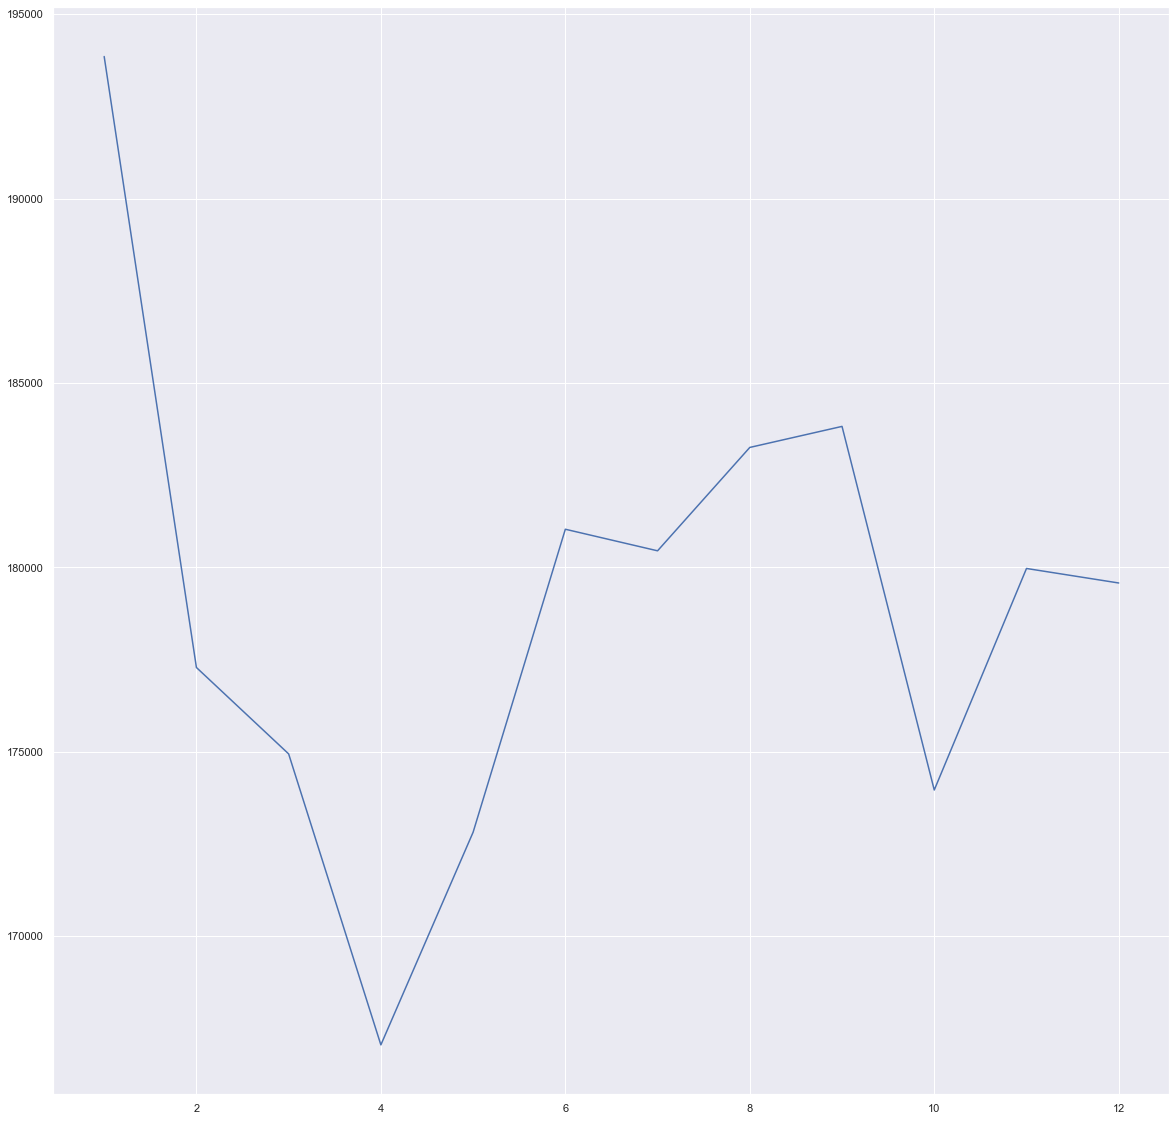

In [67]:
#looking for seasonal trends in saleprice based the on average saleprice in the month sold

mean_saleprice = amesprice.groupby('MoSold').mean()['SalePrice']
plt.plot(mean_saleprice)
print(mean_saleprice)

In [68]:
'''Looking at the average sale price by month and year sold'''
avgsaleprice = amesprice.groupby(['MoSold', 'YrSold']).mean()['SalePrice']
print(avgsaleprice)

MoSold  YrSold
1       2006      193051.666667
        2007      204752.750000
        2008      184847.666667
        2009      188005.812500
        2010      193368.238095
2       2006      188007.857143
        2007      163981.791667
        2008      193429.440000
        2009      171429.720000
        2010      171013.461538
3       2006      176295.300000
        2007      174905.978723
        2008      164235.818182
        2009      177780.813953
        2010      178828.413043
4       2006      164462.952381
        2007      161389.047619
        2008      160029.789474
        2009      184601.111111
        2010      166394.136364
5       2006      167335.522388
        2007      172200.226190
        2008      172453.026316
        2009      174817.126984
        2010      177211.041096
6       2006      172279.662921
        2007      182641.114583
        2008      185854.237624
        2009      188315.336735
        2010      173366.213333
7       2006      173263.

              BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  \
BsmtFinSF1      1.000000         NaN        NaN     0.512920      0.632841   
BsmtFinSF2           NaN         1.0        NaN          NaN           NaN   
BsmtUnfSF            NaN         NaN        1.0          NaN           NaN   
TotalBsmtSF     0.512920         NaN        NaN     1.000000           NaN   
BsmtFullBath    0.632841         NaN        NaN          NaN      1.000000   
BsmtHalfBath         NaN         NaN        NaN          NaN           NaN   
SalePrice            NaN         NaN        NaN     0.652494           NaN   

              BsmtHalfBath  SalePrice  
BsmtFinSF1             NaN        NaN  
BsmtFinSF2             NaN        NaN  
BsmtUnfSF              NaN        NaN  
TotalBsmtSF            NaN   0.652494  
BsmtFullBath           NaN        NaN  
BsmtHalfBath           1.0        NaN  
SalePrice              NaN   1.000000  
['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'

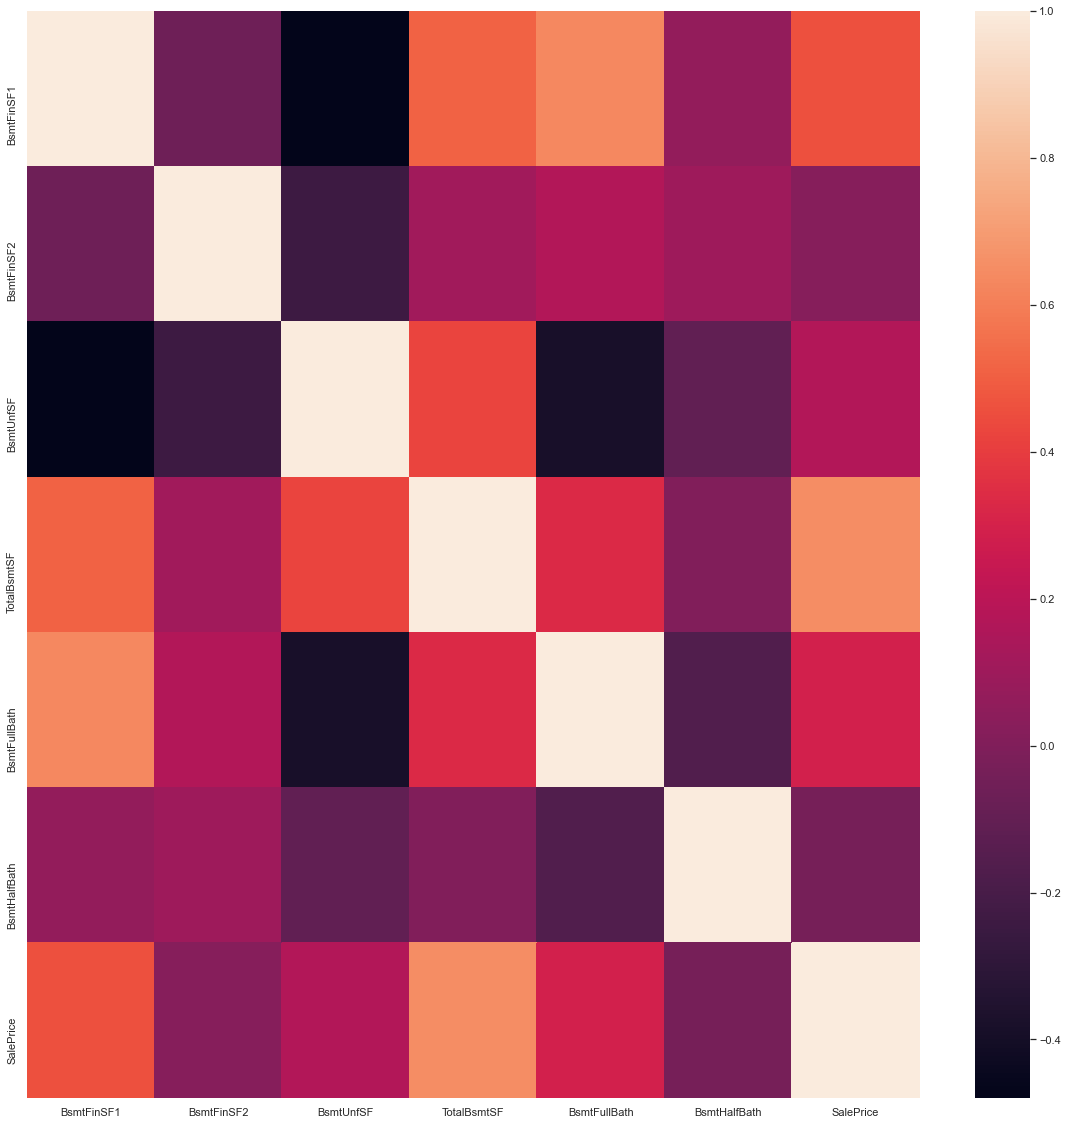

In [69]:
'''Looking at the basement columns originally null values- 
Seeing if theres any correlation of certain basement values with SalesPrice or with each other'''
                       
                       
basementfeat= [col for col in amesprice.columns if 'Bsmt' in col]  
corr4 = pd.concat([amesprice[basementfeat], amesprice['SalePrice']], axis=1).corr()
sns.heatmap(corr4)
print(corr4[corr4>0.5])
print(basementfeat)

['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']
              BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  \
BsmtFinSF1      1.000000   -0.058776  -0.480169     0.512920      0.632841   
BsmtFinSF2     -0.058776    1.000000  -0.242104     0.110279      0.169600   
BsmtUnfSF      -0.480169   -0.242104   1.000000     0.422157     -0.382440   
TotalBsmtSF     0.512920    0.110279   0.422157     1.000000      0.330926   
BsmtFullBath    0.632841    0.169600  -0.382440     0.330926      1.000000   
BsmtHalfBath    0.067588    0.101454  -0.108481     0.001384     -0.163850   
SalePrice       0.461070    0.022668   0.168060     0.652494      0.290755   

              BsmtHalfBath  SalePrice  
BsmtFinSF1        0.067588   0.461070  
BsmtFinSF2        0.101454   0.022668  
BsmtUnfSF        -0.108481   0.168060  
TotalBsmtSF       0.001384   0.652494  
BsmtFullBath     -0.163850   0.290755  
BsmtHalfBath      1.000000  -0.03

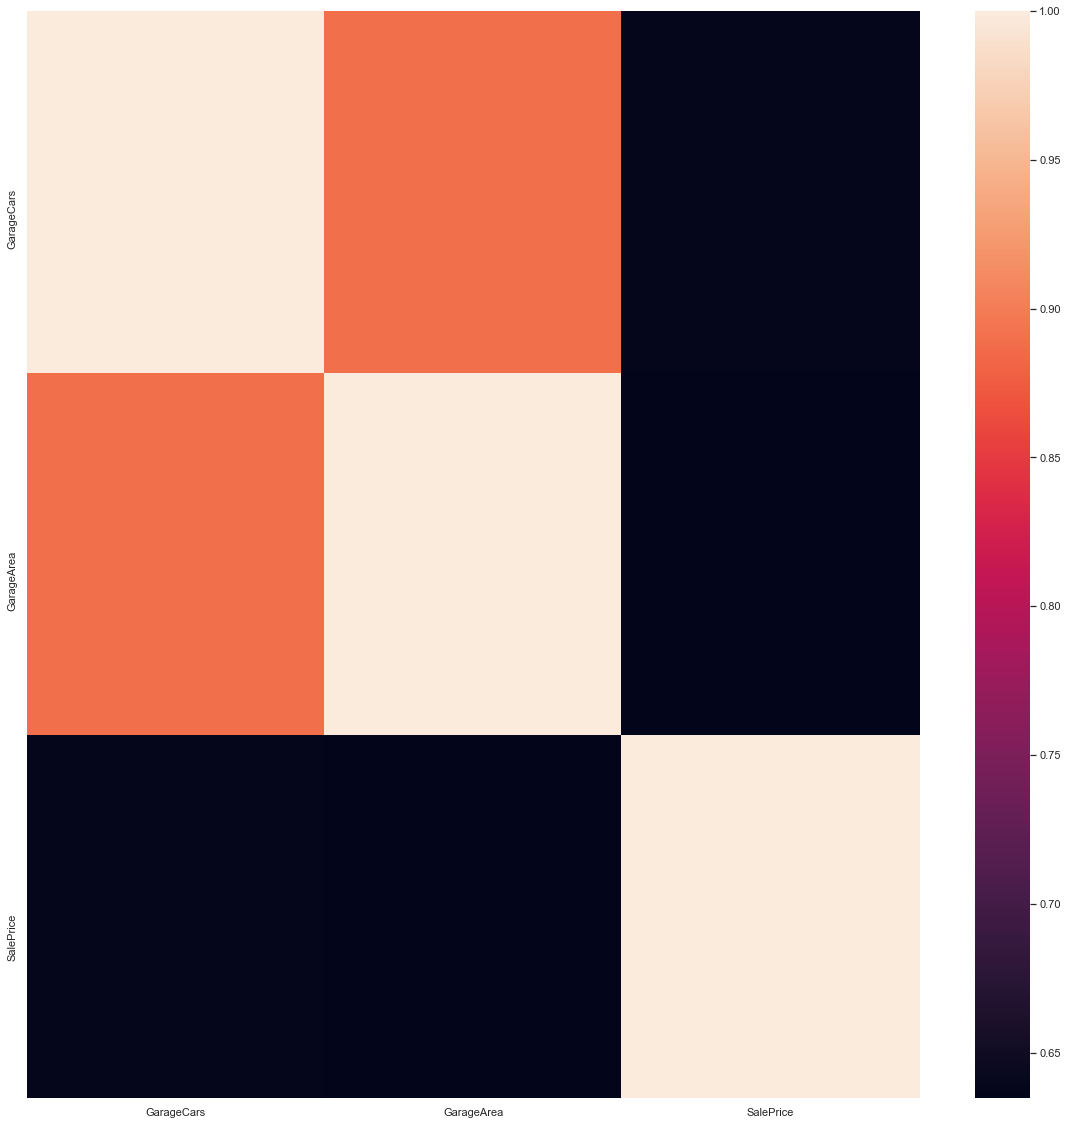

In [70]:
'''Looking at the garage features of the dataset and seeing if there is any correlation with 
other garage features or the sale price'''

garagefeat= [col for col in amesprice.columns if 'Garage' in col]
corr5 = pd.concat([amesprice[garagefeat], amesprice['SalePrice']], axis=1).corr()
sns.heatmap(corr5)
print(garagefeat)
print(corr4)

In [ ]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

# Starting the Modeling Process for the AmesPrice dataframe


In [90]:
amesprice1=amesprice.drop(['SalePrice', 'SaleType', 'SaleCondition', 
                           'MoSold', 'YrSold'], axis=1)

In [91]:
#separate types of columns/features
categorical_features = amesprice1.select_dtypes(include = ["object"]).columns
numerical_features = amesprice1.select_dtypes(exclude = ["object"]).columns

#separating the features into dataframes
amesnum = amesprice1[numerical_features]
amescat = amesprice1[categorical_features]

In [99]:
dummies=pd.get_dummies(amescat, drop_first=True)
x=pd.concat([amesprice[numerical_features], dummies], axis=1)
y=amesprice['SalePrice']

In [100]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

In [101]:
lm=LinearRegression()
lm.fit(x_train,y_train)
lm.fit(x_test, y_test)
print('The R2 for this training model is :',lm.score(x_train,y_train))
print('The R2 for this test model is :',lm.score(x_test, y_test))
print('The intercept for this model is:', lm.intercept_)
print('The coefficients for this model are:', lm.coef_)
print('The prediction with linear model:', lm.predict(x))

The R2 for this training model is : 0.8358409753407381
The R2 for this test model is : 0.9566931010743701
The intercept for this model is: -751599.0357617807
The coefficients for this model are: [-3.41248052e+00  3.22208905e-05  2.89654448e+01 -1.22282242e+02
 -2.03233363e-01  8.12781561e+03  3.91657592e+03  2.99564190e+02
  3.56419565e+01  2.85571732e+01  9.42105433e+00  7.17222462e+00
 -5.55818188e+00  1.10353337e+01  1.90124716e+01  1.18207784e+01
 -1.87559502e+00  8.62830982e+03  7.61164847e+02 -8.89378545e+02
 -8.06132416e+02 -1.14550078e+03 -6.65380701e+03  2.06198466e+03
  6.18221756e+03  5.78886590e+03  3.51863634e+01  1.10842215e+00
 -1.37211413e+01 -5.30285874e+00  7.62779496e-01  2.27686517e+01
  5.72480765e+01  1.20986290e+00 -1.51407354e+04 -1.10139946e+04
  4.27211918e+04 -5.87622554e+03 -6.19482837e+03 -4.49540791e+03
  2.08228437e+04  1.37356206e+04 -5.39711952e+02  3.51615522e+03
  3.11788003e+04 -3.11765079e+03  1.91348318e+04  1.44734620e+04
  3.73386668e+03 -1.01348

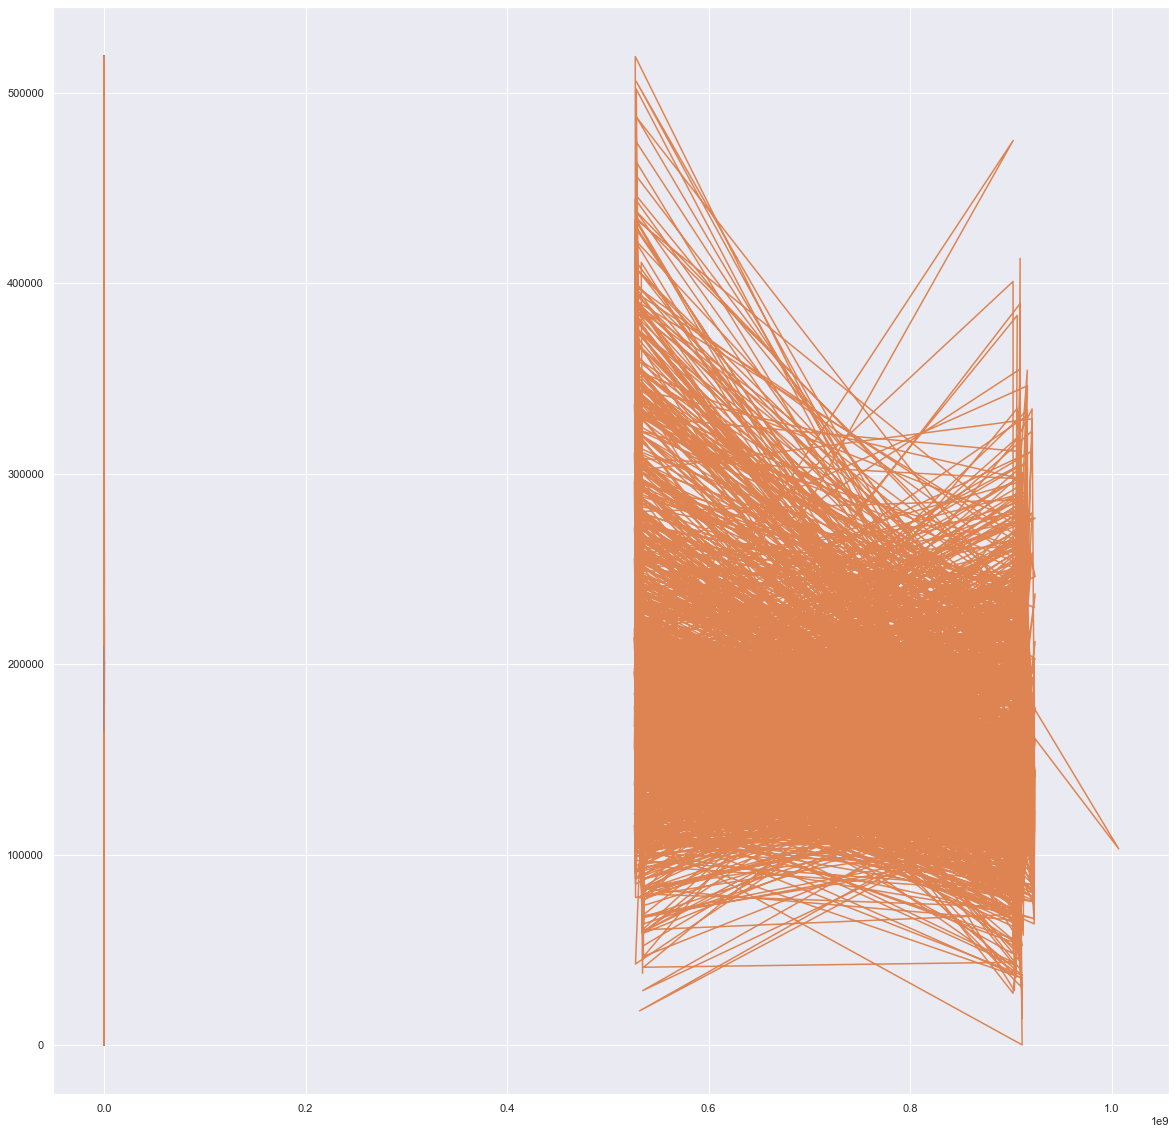

In [102]:
plt.plot(x,lm.predict(x), label='predicted')

In [103]:
#calculating the statistical values for the model
import statsmodels.api as sm


x_add_const=sm.add_constant(x_train)
ols=sm.OLS(y_train, x_add_const)
ans=ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     86.11
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:21:11   Log-Likelihood:                -20181.
No. Observations:                1806   AIC:                         4.099e+04
Df Residuals:                    1493   BIC:                         4.271e+04
Df Model:                         312                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.726e+05 

In [96]:
'''if we need to scale the model then use this'''
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
scaleType='standard'

if scaleType=='standard':
    scaler=StandardScaler()
elif scaleType=='MinMax':
    scaler=minmaxscaler()
elif scaleType=='MaxAbsScaler':
    scaler=MaxAbsScaler()

    scaler.fit(x_train)
    x_train_scaled=scaler.transform(x_train)
    x_test_scaled=scaler.transform(x_test)
    
x_add_const=sm.add_constant(x_train)
ols=sm.OLS(y_train, x_add_const)
ans=ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     419.9
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:16:03   Log-Likelihood:                -20955.
No. Observations:                1806   AIC:                         4.198e+04
Df Residuals:                    1773   BIC:                         4.216e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.212e+06   9.49e+04    -12.773

In [112]:
'''Model Selection and Gridsearch'''

for C in [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]:
    logistic = LogisticRegression(C=C, solver='liblinear')
    logistic.fit(x_train, y_train)
    print("C =", C)
    print("Test Score", logistic.score(x_test, y_test), "\n")

C = 0.0001
Test Score 0.00904392764857881 

C = 0.01
Test Score 0.00904392764857881 

C = 1
Test Score 0.00904392764857881 

C = 100
Test Score 0.00904392764857881 

C = 10000
Test Score 0.00904392764857881 

C = 1000000
Test Score 0.00904392764857881 

C = 100000000
Test Score 0.00904392764857881 



In [113]:
kfold = KFold(n_splits=3)
for training_idx, validation_idx in kfold.split(x_train, y_train):
    print(training_idx, " consists of {} indexes.".format(len(training_idx)))
    print(validation_idx, " consists of {} indexes.".format(len(validation_idx)))
    print("\n")

[ 602  603  604 ... 1803 1804 1805]  consists of 1204 indexes.
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

In [118]:
lm = LogisticRegression(C=1, solver='liblinear')

scores = []
for training_idx, validation_idx in kfold.split(x_train, y_train):
    x_ = x_train.iloc[training_idx,:]
    y_ = y_train.iloc[training_idx]
    lm.fit(x_, y_)
    scores.append(
        lm.score(x_train.iloc[validation_idx], y_train.iloc[validation_idx]))
    
print(
    "The 'cross-validation score' for the logistic regression with C={} is {}".format(
        lm.get_params()["C"], np.mean(scores)))

The 'cross-validation score' for the logistic regression with C=1 is 0.008859357696566999


In [120]:
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
for training_idx, validation_idx in skfold.split(x_train, y_train):
    print("The churn rate of the training set of this fold is {}.".format(y_train.iloc[training_idx].mean()))
    print("The churn rate of the validation set of this fold is {}.".format(y_train.iloc[validation_idx].mean()))
    print("\n")

The churn rate of the training set of this fold is 175635.7292358804.
The churn rate of the validation set of this fold is 183006.7458471761.


The churn rate of the training set of this fold is 179500.7865448505.
The churn rate of the validation set of this fold is 175276.63122923588.


The churn rate of the training set of this fold is 179141.68853820598.
The churn rate of the validation set of this fold is 175994.82724252492.




/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


In [122]:
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

result = {}
for C in [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]:
    logistic = LogisticRegression(C=C, solver='liblinear')
    result[C] = cross_val_score(logistic, x_train, y_train, cv=skfold).mean()
    
result

/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The 

{0.0001: 0.011074197120708748,
 0.01: 0.011074197120708748,
 1: 0.011074197120708748,
 100: 0.011074197120708748,
 10000: 0.011074197120708748,
 1000000: 0.011074197120708748,
 100000000: 0.011074197120708748}

In [124]:
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
logistic = LogisticRegression(solver='liblinear')
params = {
    "C": [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]
}

gs = GridSearchCV(logistic, params, cv=skfold)
gs.fit(x_train, y_train)
gs.cv_results_['mean_test_score']
gs.best_estimator_
gs.score(x_test, y_test)

/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


0.00904392764857881

In [126]:
#pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

logistic = LogisticRegression(max_iter=500, solver='liblinear', class_weight="balanced")
pipe = Pipeline([ 
    ("standardize", StandardScaler()), ('logit', logistic)])

params = {
    "logit__C": [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]
}

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(pipe, params, scoring="roc_auc", cv=skfold)

start= time.time()
gs.fit(x_train, y_train)
print(time.time() - start)

print("The best parameters are: ", gs.best_params_)
print("The score roc_auc score of the final model: ", gs.score(X_test, y_test))
print("An alternative way to obtain roc_auc: ", roc_auc_score(y_test, gs.predict_proba(X_test)[:,1]))
get_confusion_matrix(gs, X_test, y_test)

NameError: name 'time' is not defined